In [1]:
# %load_ext autoreload
# %autoreload 2
import xarray as xr
from odc.geo.xr import assign_crs, xr_reproject

from ocr import catalog
from ocr.config import OCRConfig
from ocr.conus404 import geo_sel

# from ocr.risks.fire import calculate_wind_adjusted_risk
from ocr.risks.fire import apply_wind_directional_convolution, create_weighted_composite_bp_map

In [2]:
config = OCRConfig(storage_root='/tmp/ocr-testing', debug=True)
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=True), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=True), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=True)

In [3]:
# def classify_wind(
#     riley_30m_4326: xr.Dataset,
#     wind_direction_distribution_30m_4326: xr.DataArray,
#     unburnable_mask_climate_run_30m_4326: xr.DataArray,
#     riley_270m_5070: xr.Dataset,
# ) -> xr.DataArray:
#     """Classify wind by applying directional convolution and creating a weighted composite burn probability map.

#     Parameters
#     ----------
#     climate_run_subset : xr.Dataset
#         Subset of the climate run dataset containing burn probability ('BP') data.
#     wind_direction_distribution : xr.DataArray
#         Wind direction distribution data array.
#     unburnable_mask_climate_run : xr.DataArray
#         Unburnable mask for the climate run dataset.

#     Returns
#     -------
#     wind_informed_bp_float_corrected : xr.DataArray
#         Wind-informed burn probability data array with corrected coordinates.
#     """

#     blurred_bp_30m_4326 = apply_wind_directional_convolution(riley_30m_4326['BP'], iterations=3)
#     wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(
#         blurred_bp_30m_4326, wind_direction_distribution_30m_4326
#     )
#     wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
#     ## average wind_informed_bp to 270m
#     wind_informed_bp_270m_5070 = xr_reproject(
#         wind_informed_bp_30m_4326, how=riley_270m_5070.odc.geobox, resampling='average'
#     )
#     ##  put non-zero numbers into where zero numbers were before
#     riley_filled_270m_5070 = xr.where(
#         riley_270m_5070.BP == 0, wind_informed_bp_270m_5070, riley_270m_5070
#     )
#     riley_filled_270m_5070 = assign_crs(riley_filled_270m_5070, 'EPSG:5070')
#     riley_filled_30m_4326 = xr_reproject(
#         riley_filled_270m_5070,
#         how=wind_informed_bp_30m_4326.odc.geobox,
#         resampling='bilinear',
#         resolution='same',
#     )
#     riley_filled_30m_4326 = riley_filled_30m_4326.assign_coords(
#         {
#             'latitude': wind_informed_bp_30m_4326.latitude,
#             'longitude': wind_informed_bp_30m_4326.longitude,
#         }
#     )

#     # retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid
#     # wind_informed_bp_corrected = xr.where(
#     #     unburnable_mask_climate_run_30m_4326==0, riley_filled_30m_4326, wind_informed_bp_30m_4326
#     # )

#     # return wind_informed_bp_corrected['BP'], riley_filled_30m_4326, wind_informed_bp_30m_4326
#     return wind_informed_bp_30m_4326

In [4]:
region_id = 'y8_x4'
y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id=region_id)
y_slice, x_slice

riley_2011_30m_4326 = catalog.get_dataset('2011-climate-run-30m-4326').to_xarray()[['BP']]
riley_2047_30m_4326 = catalog.get_dataset('2047-climate-run-30m-4326').to_xarray()[['BP']]
unburnable_mask_riley_2011_30m_4326 = catalog.get_dataset(
    'unburnable-mask-2011-climate-run-30m-4326'
).to_xarray()
unburnable_mask_riley_2047_30m_4326 = catalog.get_dataset(
    'unburnable-mask-2047-climate-run-30m-4326'
).to_xarray()
riley_2011_270m_5070 = catalog.get_dataset('2011-climate-run').to_xarray()[['BP', 'spatial_ref']]
riley_2011_270m_5070 = assign_crs(riley_2011_270m_5070, 'EPSG:5070')
riley_2047_270m_5070 = catalog.get_dataset('2047-climate-run').to_xarray()[['BP', 'spatial_ref']]
riley_2047_270m_5070 = assign_crs(riley_2047_270m_5070, 'EPSG:5070')


rps_30 = catalog.get_dataset('USFS-wildfire-risk-communities-4326').to_xarray()[
    ['BP', 'CRPS', 'RPS']
]

rps_30_subset = rps_30.sel(latitude=y_slice, longitude=x_slice)
riley_2011_30m_4326_subset = riley_2011_30m_4326.sel(latitude=y_slice, longitude=x_slice)
riley_2047_30m_4326_subset = riley_2047_30m_4326.sel(latitude=y_slice, longitude=x_slice)
unburnable_mask_riley_2011_30m_4326_subset = unburnable_mask_riley_2011_30m_4326.sel(
    latitude=y_slice, longitude=x_slice
).unburnable
unburnable_mask_riley_2047_30m_4326_subset = unburnable_mask_riley_2047_30m_4326.sel(
    latitude=y_slice, longitude=x_slice
).unburnable
riley_2011_270m_5070_subset = geo_sel(
    riley_2011_270m_5070,
    bbox=[x_slice.start, y_slice.stop, x_slice.stop, y_slice.start],
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
)
riley_2047_270m_5070_subset = geo_sel(
    riley_2047_270m_5070,
    bbox=[x_slice.start, y_slice.stop, x_slice.stop, y_slice.start],
    crs_wkt=riley_2047_270m_5070.spatial_ref.attrs['crs_wkt'],
)

reprojected_riley = xr_reproject(
    riley_2011_270m_5070_subset,
    how=riley_2011_30m_4326_subset.odc.geobox,
    resampling='nearest',
    resolution='same',
)

## make my own unburnable mask based upon the riley_5070 subsets i load above
# unburnable_mask_riley_2011_4326_30m = ((xr_reproject(riley_2011_270m_5070_subset,
#                  how=wind_informed_2011_bp_30m_4326.odc.geobox,
#                  resampling='nearest',
#                  resolution='same')['BP'])==0)

# unburnable_mask_riley_2047_4326_30m = ((xr_reproject(riley_2047_270m_5070_subset,
#                  how=wind_informed_2047_bp_30m_4326.odc.geobox,
#                  resampling='nearest',
#                  resolution='same')['BP'])==0)

wind_direction_distribution_30m_4326 = (
    catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution-reprojected')
    .to_xarray()
    .wind_direction_distribution.sel(latitude=y_slice, longitude=x_slice)
    .load()


/Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [46]:
wind_direction_distribution_30m_4326 = wind_direction_distribution_30m_4326
unburnable_mask_climate_run_30m_4326 = unburnable_mask_riley_2011_30m_4326_subset
riley_270m_5070 = riley_2011_270m_5070_subset

import cv2 as cv
## gap fill riley 270 only filling NaN pixels which are surrounded by valid data on four sides
valid_pixels = (riley_270m_5070['BP'] > 0)
# shifting will introduce NaNs! So we need to clip along boundaries
print('1')
surrounded_by_four_valid_values = ((valid_pixels.shift(x=1) + valid_pixels.shift(x=-1) + valid_pixels.shift(y=1) + valid_pixels.shift(y=-1))==4)
# 270m 5070 projection mask of every pixel which is surrounded by valid data on four sides 
nans_surrounded_by_four_valid_values = xr.where((valid_pixels==0) & surrounded_by_four_valid_values, 1, 0)
# where nans_surrounded_by_four_valid_values is true, fill with a 3x3 moving window average of valid pixels
rolling_mean = riley_270m_5070.rolling({"x":3,"y":3}, 
                                                center=True, 
                                                min_periods=1).mean(skipna=True)
print('2')
gap_filled_riley_2011_270m_5070_subset = xr.where(nans_surrounded_by_four_valid_values, rolling_mean, riley_270m_5070)

wind_direction_distribution_30m_4326 = assign_crs(wind_direction_distribution_30m_4326, 'EPSG:4326')
gap_filled_riley_2011_270m_5070_subset = assign_crs(gap_filled_riley_2011_270m_5070_subset, 'EPSG:5070')
print('ciao')

1
2
ciao


In [47]:
## reproject to the 30m 4326 projection (use riley_30m_4326 as variable name)
riley_30m_4326 = xr_reproject(
        gap_filled_riley_2011_270m_5070_subset, how=wind_direction_distribution_30m_4326.odc.geobox, resampling='nearest'
    )
riley_30m_4326 = riley_30m_4326.assign_coords(
    {
        'latitude': wind_direction_distribution_30m_4326.latitude,
        'longitude': wind_direction_distribution_30m_4326.longitude,
    }
)
blurred_bp_30m_4326 = apply_wind_directional_convolution(riley_30m_4326['BP'], iterations=3)
wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(
    blurred_bp_30m_4326, wind_direction_distribution_30m_4326
)
print('10')
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')

10


In [16]:
# print('10')
# wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
# # average wind_informed_bp to 270m. do we still need to do this?
# wind_informed_bp_270m_5070 = xr_reproject(
#     wind_informed_bp_30m_4326, how=riley_270m_5070.odc.geobox, resampling='average'
# )
# # gap fill unburnable pixels in riley which are surrounded on four sides by burnable pixels
# #

10


In [43]:
# # put wind-blurred numbers into where riley still has zero values
# riley_filled_270m_5070 = xr.where(
#     riley_270m_5070.BP == 0, wind_informed_bp_270m_5070, riley_270m_5070
# )
# riley_filled_270m_5070 = assign_crs(riley_filled_270m_5070, 'EPSG:5070')
# riley_filled_30m_4326 = xr_reproject(
#     riley_filled_270m_5070,
#     how=wind_direction_distribution_30m_4326.odc.geobox,
#     resampling='nearest',
#     resolution='same',
# )   

In [ ]:
send to anderson!!
# def reproject_raster():
    # template_ds = # load some dataset (likely either unburnablem ask or wind direction ds)
    # # whose coords we like and they don't change inside this function and so we can use as template

    # xr_reproject(in_ds, template_ds)
    # assert that ds coords aren't too different from template coords (e.g. crs is the same and resolution differnce is tiny)

    # if off by a tiny ammount from standard coords
    # then:  # ds = ds.assign_coords(
    #         {
    #             'latitude': template_ds.latitude,
    #             'longitude': template_ds.longitude,
    #         }
    #     )
    #               return ds
    # if off by a bit amount
    # then: fail

In [50]:
riley_filled_30m_4326 = riley_filled_30m_4326.assign_coords(
    {
        'latitude': wind_direction_distribution_30m_4326.latitude,
        'longitude': wind_direction_distribution_30m_4326.longitude,
    }
)

wind_informed_bp_30m_4326 = wind_informed_bp_30m_4326.assign_coords(
    {
        'latitude': wind_direction_distribution_30m_4326.latitude,
        'longitude': wind_direction_distribution_30m_4326.longitude,
    }
)
# gap fill any zeroes remaining in riley using the wind-smeared numbers

# retain original Riley et al. (2025) burn probability where there are valid numbers at a 270m scale (but based upon
# the dataset reprojected and interpolated to a 30m EPSG:4326 grid). anywhere there are no valid numbers use the
# wind smeared values
wind_informed_bp_combined = xr.where(
    riley_30m_4326['BP'] == 0, wind_informed_bp_30m_4326, riley_30m_4326['BP']
)

# smooth using a 21x21 Gaussian filter
smoothed_final_bp = cv.GaussianBlur(wind_informed_bp_combined.values, (21, 21), 0)
smoothed_final_bp_ds = xr.Dataset(
    data_vars={'BP': ((wind_direction_distribution_30m_4326.sel(wind_direction=0).dims, smoothed_final_bp.astype(np.float32)))},
    coords=wind_direction_distribution_30m_4326.coords,
)

In [36]:
bbox = [-122.25, 37.39, -122.15, 37.42]

In [34]:
import numpy as np
# select one wind_direction so we can use the dims as a template

smoothed_final_bp_ds = xr.Dataset(
    data_vars={'BP': ((wind_direction_distribution_30m_4326.sel(wind_direction=0).dims, 
                       smoothed_final_bp.astype(np.float32)))},
    coords=wind_direction_distribution_30m_4326.coords,
)

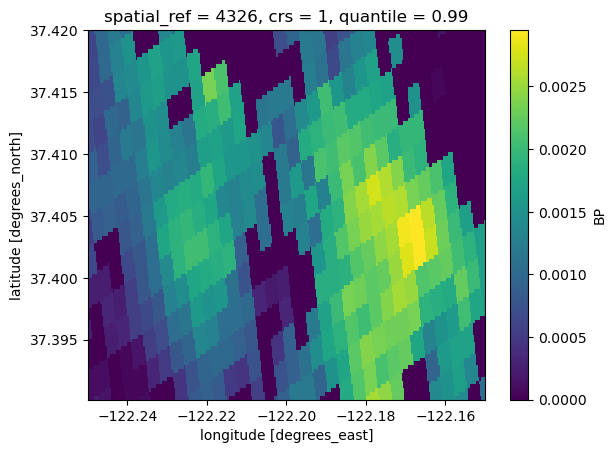

In [52]:
riley_30m_4326.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

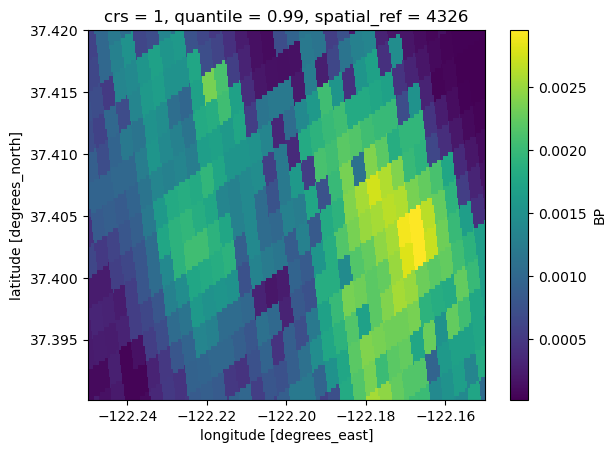

In [51]:
riley_filled_30m_4326.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

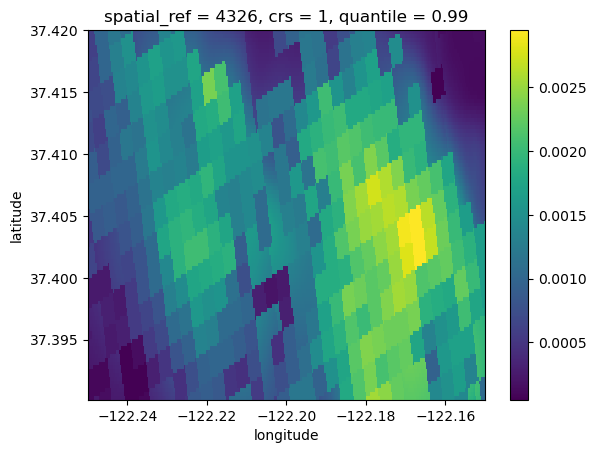

In [55]:
wind_informed_bp_combined.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).plot()

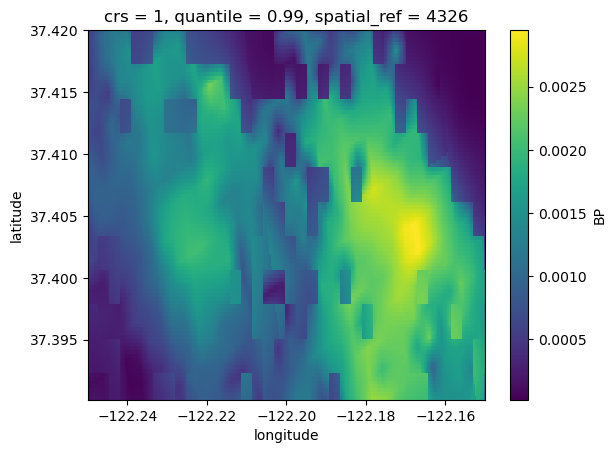

In [38]:
wind_informed_bp_corrected.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

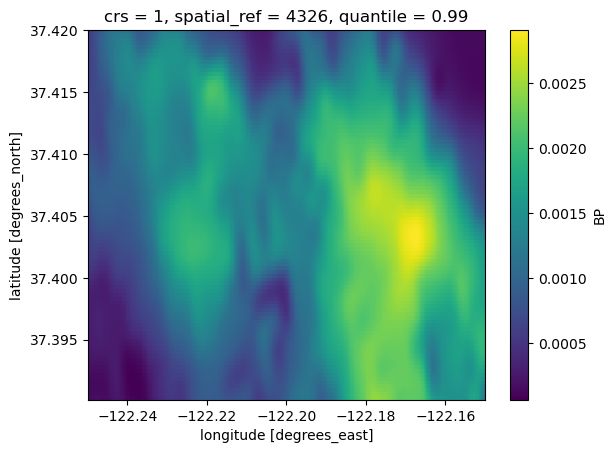

In [56]:
smoothed_final_bp_ds.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

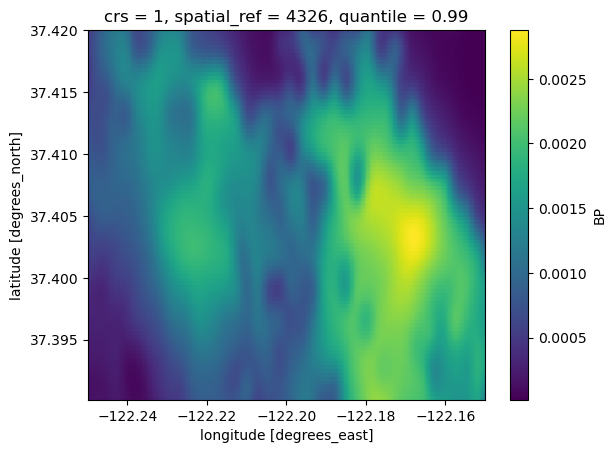

In [37]:
smoothed_final_bp_ds.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

In [5]:
%%time
%pdb on
from ocr.risks.fire import create_wind_informed_burn_probability
da = create_wind_informed_burn_probability(wind_direction_distribution_30m_4326, 
                                           unburnable_mask_riley_2011_30m_4326_subset, riley_2011_270m_5070_subset)

Automatic pdb calling has been turned ON
1
2
ciao
3
10
CPU times: user 1min 33s, sys: 13.7 s, total: 1min 47s
Wall time: 1min 38s


CoordinateValidationError: conflicting sizes for dimension 'latitude': length 4 on the data but length 6000 on coordinate 'latitude'

> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/coordinates.py(1326)validate_dataarray_coords()
   1324         for d, s in v.sizes.items():
   1325             if d in sizes and s != sizes[d]:
-> 1326                 raise CoordinateValidationError(
   1327                     f"conflicting sizes for dimension {d!r}: "
   1328                     f"length {sizes[d]} on the data but length {s} on "



ipdb>  u


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/coordinates.py(1102)_update_coords()
   1100         self, coords: dict[Hashable, Variable], indexes: dict[Hashable, Index]
   1101     ) -> None:
-> 1102         validate_dataarray_coords(
   1103             self._data.shape, Coordinates._construct_direct(coords, indexes), self.dims
   1104         )



ipdb>  u


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/coordinates.py(634)update()
    632         self._drop_coords(self._names - coords_to_align._names)
    633 
--> 634         self._update_coords(coords, indexes)
    635 
    636     def assign(self, coords: Mapping | None = None, **coords_kwargs: Any) -> Self:



ipdb>  u


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/common.py(664)assign_coords()
    662             results = self._calc_assign_results(coords_combined)
    663 
--> 664         data.coords.update(results)
    665         return data
    666 



ipdb>  u


> /Users/orianachegwidden/ocr/ocr/risks/fire.py(476)create_wind_informed_burn_probability()
    474     )
    475 
--> 476     wind_informed_bp_30m_4326 = wind_informed_bp_30m_4326.assign_coords(
    477         {
    478             'latitude': wind_direction_distribution_30m_4326.latitude,



ipdb>  wind_informed_bp_30m_4326.coords


Coordinates:
  * latitude     (latitude) float64 32B 37.7 37.7 37.7 37.7
  * longitude    (longitude) float64 272B -122.8 -122.8 -122.8 ... -122.8 -122.8
    spatial_ref  int32 4B 4326
    crs          int64 8B 1
    quantile     float64 8B 0.99


ipdb>  wind_informed_bp_30m_4326.latitude.shape


(4,)


ipdb>  u


> <timed exec>(3)<module>()



ipdb>  u


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/IPython/core/magics/execution.py(1434)time()
   1432             st = clock2()
   1433             try:
-> 1434                 exec(code, glob, local_ns)
   1435                 out = None
   1436                 # multi-line %%time case



ipdb>  u


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/IPython/core/magics/execution.py(1470)time()
   1468         if interrupt_occured:
   1469             if exit_on_interrupt and captured_exception:
-> 1470                 raise captured_exception
   1471             return
   1472         return out



ipdb>  u


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/IPython/core/interactiveshell.py(2565)run_cell_magic()
   2563             with self.builtin_trap:
   2564                 args = (magic_arg_s, cell)
-> 2565                 result = fn(*args, **kwargs)
   2566 
   2567             # The code below prevents the output from being displayed



ipdb>  u


> /var/folders/q4/3p8rs8s17q13wbkj0y58w6hm0000gn/T/ipykernel_37150/2408888757.py(1)<module>()
----> 1 get_ipython().run_cell_magic('time', '', '%pdb on\nfrom ocr.risks.fire import create_wind_informed_burn_probability\nda = create_wind_informed_burn_probability(wind_direction_distribution_30m_4326, \n                                           unburnable_mask_riley_2011_30m_4326_subset, riley_2011_270m_5070_subset)\n')



ipdb>  u


*** all frames above hidden, use `skip_hidden False` to get get into those.


ipdb>  d


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/IPython/core/interactiveshell.py(2565)run_cell_magic()
   2563             with self.builtin_trap:
   2564                 args = (magic_arg_s, cell)
-> 2565                 result = fn(*args, **kwargs)
   2566 
   2567             # The code below prevents the output from being displayed



ipdb>  d


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/IPython/core/magics/execution.py(1470)time()
   1468         if interrupt_occured:
   1469             if exit_on_interrupt and captured_exception:
-> 1470                 raise captured_exception
   1471             return
   1472         return out



ipdb>  d


> /Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/IPython/core/magics/execution.py(1434)time()
   1432             st = clock2()
   1433             try:
-> 1434                 exec(code, glob, local_ns)
   1435                 out = None
   1436                 # multi-line %%time case



ipdb>  d


> <timed exec>(3)<module>()



ipdb>  d


> /Users/orianachegwidden/ocr/ocr/risks/fire.py(476)create_wind_informed_burn_probability()
    474     )
    475 
--> 476     wind_informed_bp_30m_4326 = wind_informed_bp_30m_4326.assign_coords(
    477         {
    478             'latitude': wind_direction_distribution_30m_4326.latitude,



ipdb>  exit


In [9]:
valid_pixels = (riley_2011_270m_5070_subset['BP'] > 0)

In [10]:
surrounded_by_four_valid_values = ((valid_pixels.shift(x=1) + valid_pixels.shift(x=-1) + valid_pixels.shift(y=1) + valid_pixels.shift(y=-1))==4)

In [19]:
# 270m 5070 projection mask of every 
nans_surrounded_by_four_valid_values = xr.where((valid_pixels==0) & surrounded_by_four_valid_values, 1, 0)

In [23]:
# where nans_surrounded_by_four_valid_values is true, fill with a 3x3 moving window average of valid pixels
rolling_mean = riley_2011_270m_5070_subset.rolling({"x":3,"y":3}, 
                                                center=True, 
                                                min_periods=1).mean(skipna=True)
gap_filled_riley_2011_270m_5070_subset = xr.where(nans_surrounded_by_four_valid_values, rolling_mean, riley_2011_270m_5070_subset)

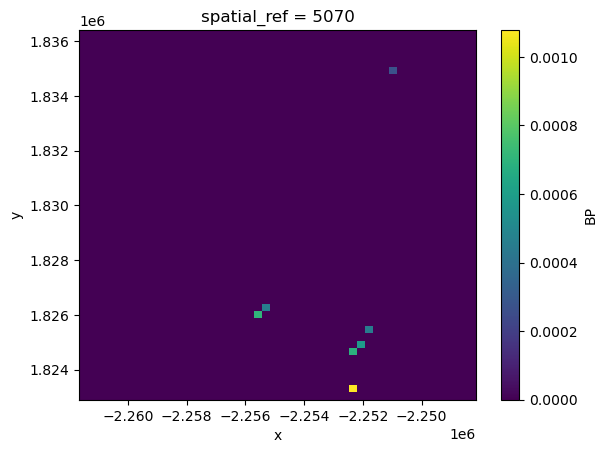

In [31]:
(gap_filled_riley_2011_270m_5070_subset - riley_2011_270m_5070_subset).isel(x=slice(350,400), y=slice(450,500)).BP.plot()

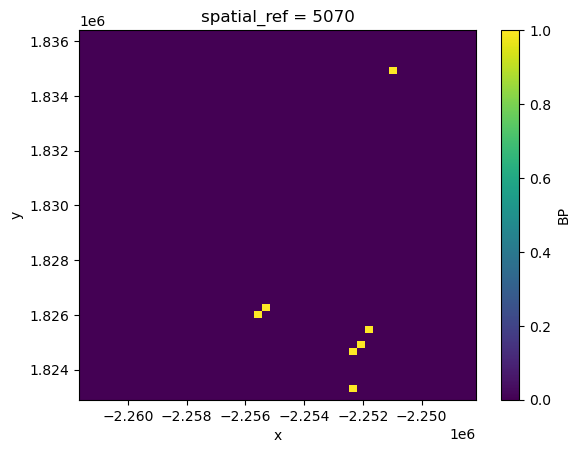

In [29]:
nans_surrounded_by_four_valid_values.isel(x=slice(350,400), y=slice(450,500)).plot()

In [140]:
# wind_informed_bp_corrected_2011 = classify_wind(
#     riley_30m_4326=reprojected_riley,
#     wind_direction_distribution_30m_4326=wind_direction_distribution_30m_4326,
#     unburnable_mask_climate_run_30m_4326=unburnable_mask_riley_2011_30m_4326_subset,
#     riley_270m_5070=riley_2011_270m_5070_subset,
# )

here


# on tuesday where do i pick up:
- i _think_ i have a working implementation of smearing that ignores zeros. but this still diminishes higher values of BP from FSIM.
- i don't think this approach is enough on its own because we are moving around BP in modeled areas ( dimnishing high values and amplifying others - moving BP into places it wasnt before) - moving it to places wehre there are valid modeled values. we only want ot interpolate in those areas, and then move it outside of there - but _how to not have weird edge effects! - perhaps do 1-pixel gap-filling and then use that as a mask of places to add to? there wil still be edge effects, but fewer - one last pass of smoothing since it's only adjusting numbers that we have already altered?
- - so i think we need to still clip back in the interpolated version of BP - how do we overcome the lack of smoothign then? could we just do it at 570 and then interpolate? or would another interpolation approach be smoother? (cubic?)
- perhaps we could do a decaying spread- that would move things outside but not as much... then it makes us have to justify our filter more and it isn't based on math at all!


In [5]:
bbox = [-122.25, 37.39, -122.15, 37.42]

# 1. create wind layer by three passes of a nan-aware wind-informed filter

In [6]:
three_iterations = apply_wind_directional_convolution(reprojected_riley.BP, iterations=3)

here2


/Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [12]:
three_iterations = three_iterations[0].assign_coords(
    {
        'latitude': wind_direction_distribution_30m_4326.latitude,
        'longitude': wind_direction_distribution_30m_4326.longitude,
    }
)
wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(
    three_iterations, wind_direction_distribution_30m_4326
)

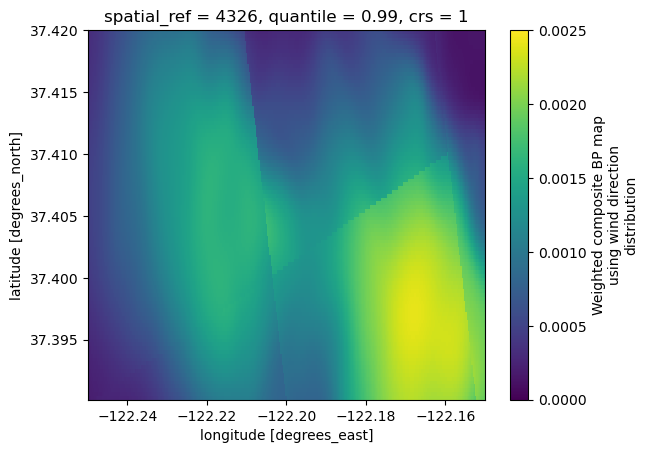

In [13]:
wind_informed_bp_30m_4326.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).plot(vmin=0, vmax=0.0025)

# 2. Fill in island NaN pixels in Riley
## extract only pixels that are surrounded on four sides by data. Options for filling:
1. fill using a moving 3x3 window of 270m data
2. fill with wind-spread data

I think it makes more sense to fill with solely the 270m data since our rationale is to adopt the numbers from surrounding wildlands.
Do we need to mask after the fact with water/unburnable using a 30m product? Will cRPS do that for us?

In [22]:
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
## average wind_informed_bp to 270m
wind_informed_bp_270m_5070 = xr_reproject(
    wind_informed_bp_30m_4326, how=riley_2011_270m_5070_subset.odc.geobox, resampling='average'
)
##  put non-zero numbers into where zero numbers were before
# riley_2011_270m_5070_subset = riley_2011_270m_5070_subset.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
#                                                                  'longitude': wind_informed_bp_30m_4326.longitude})
riley_filled_270m_5070 = xr.where(
    riley_2011_270m_5070_subset.BP == 0, wind_informed_bp_270m_5070, riley_2011_270m_5070_subset
)
riley_filled_270m_5070 = assign_crs(riley_filled_270m_5070, 'EPSG:5070')
riley_filled_30m_4326 = xr_reproject(
    riley_filled_270m_5070,
    how=wind_informed_bp_30m_4326.odc.geobox,
    resampling='cubic',
    resolution='same',
)
riley_filled_30m_4326 = riley_filled_30m_4326.assign_coords(
    {
        'latitude': wind_informed_bp_30m_4326.latitude,
        'longitude': wind_informed_bp_30m_4326.longitude,
    }
)
reprojected_riley = reprojected_riley.assign_coords(
    {
        'latitude': wind_informed_bp_30m_4326.latitude,
        'longitude': wind_informed_bp_30m_4326.longitude,
    }
)
# retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid
wind_informed_bp_corrected = xr.where(
    reprojected_riley > 0, riley_filled_30m_4326, wind_informed_bp_30m_4326
)

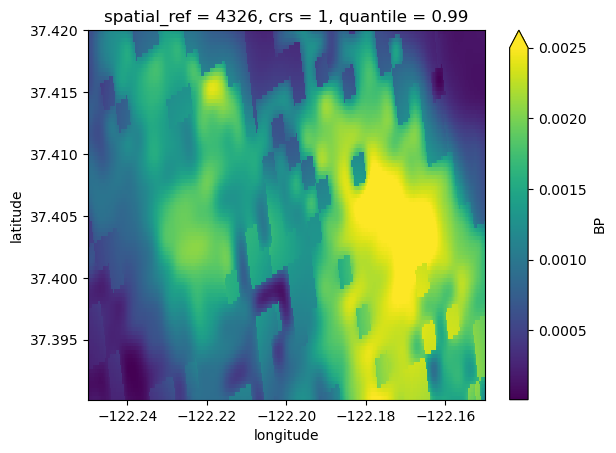

In [79]:
wind_informed_bp_corrected.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot(vmax=0.0025)

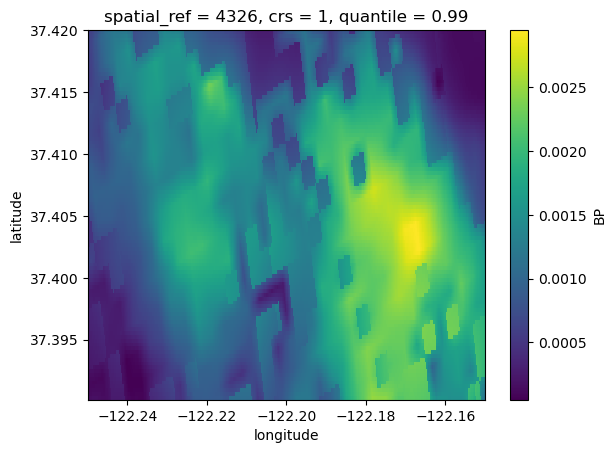

In [73]:
wind_informed_bp_corrected.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

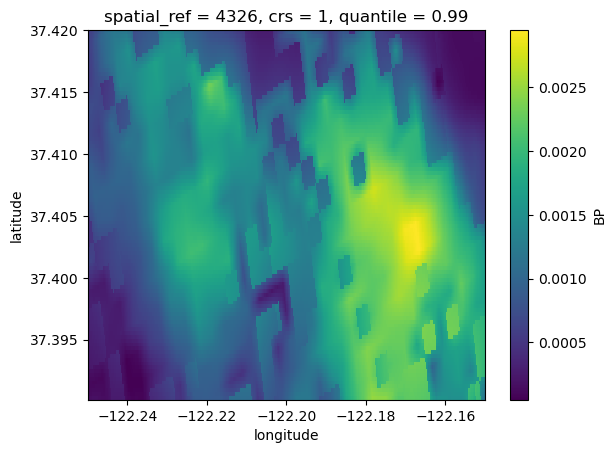

In [71]:
wind_informed_bp_corrected.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

# try all of this but with a gap-filled Riley


- tried it with gapfilling using the function below - too much smoothing!
- next up try doing it only filling a one pixel max - rioxarray interpolate_na and then make a "max 1 more" mask by doing ffill and bffil in both directions by 1 on riley
- mask = riley.ffill(max=1, dim'x') + riley.ffill(max=1, dim'y') + riley.bfill(max=1, dim'x') + riley.bfill(max=1, dim'y') + 
- interpolated_riley = intperolated_riley.where(mask > 0, intperolated_riley, 0)

In [16]:
def gap_fill_270(da):
    da = xr.where(da == 0, np.nan, da)
    da = da.rolling({'x': 3, 'y': 3}, center=True, min_periods=1).mean(skipna=True)
    da = da.fillna(0)
    return da

In [17]:
import numpy as np

gap_filled_riley_5070 = gap_fill_270(riley_2011_270m_5070_subset)

In [18]:
gap_filled_riley_5070['spatial_ref'].attrs = riley_2011_270m_5070_subset['spatial_ref'].attrs

In [21]:
reprojected_riley = xr_reproject(
    riley_2011_270m_5070_subset,
    how=riley_2011_30m_4326_subset.odc.geobox,
    resampling='nearest',
    resolution='same',
)

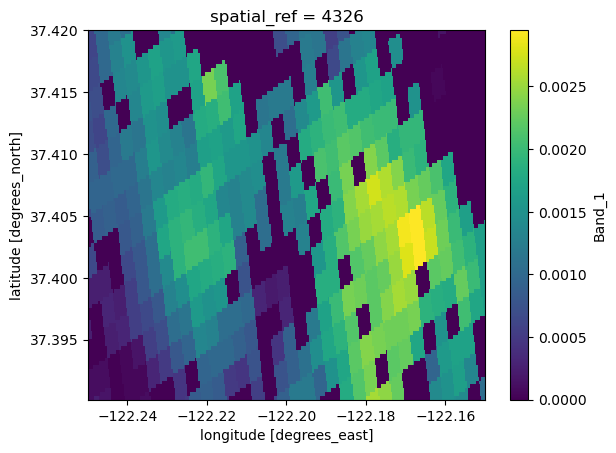

In [22]:
reprojected_riley.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

In [19]:
reprojected_riley_gapfilled = xr_reproject(
    gap_filled_riley_5070,
    how=riley_2011_30m_4326_subset.odc.geobox,
    resampling='nearest',
    resolution='same',
)

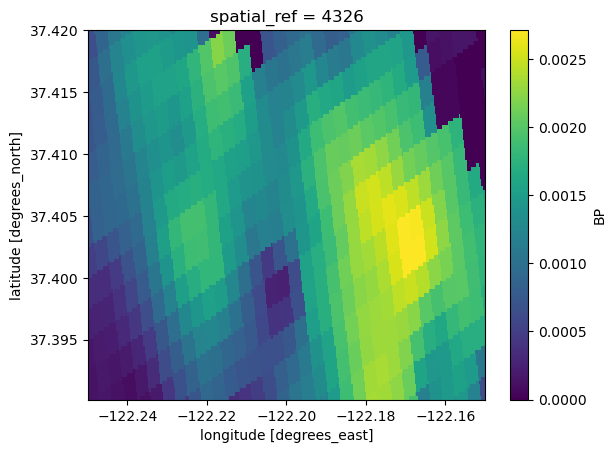

In [20]:
reprojected_riley_gapfilled.sel(
    latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
).BP.plot()

# Todo - create mask of pixels that are surrounded on four sides and then only fill in those nans with a smoothed version of the data (3x3 moving window)

In [32]:
mask = geo_sel(
    riley_2011_270m_5070_subset['BP'],
    bbox=bbox,
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
) > 0

In [36]:
import matplotlib.pyplot as plt

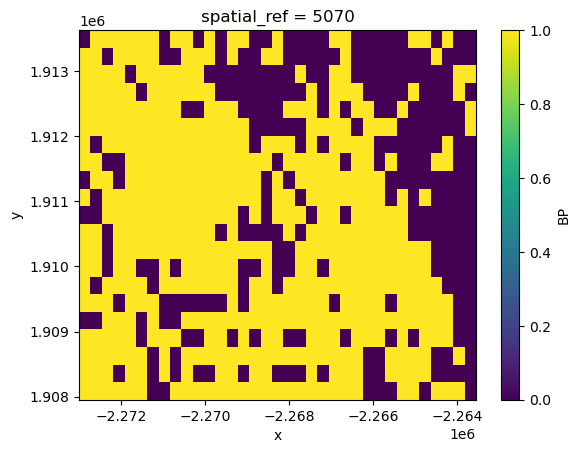

In [39]:
mask.plot()

In [42]:
xr.testing.assert_identical(mask.shift(x=1).coords, mask.coords)

In [28]:
three_iterations = apply_wind_directional_convolution(reprojected_riley.BP, iterations=3)

three_iterations = three_iterations.assign_coords(
    {
        'latitude': wind_direction_distribution_30m_4326.latitude,
        'longitude': wind_direction_distribution_30m_4326.longitude,
    }
)
wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(
    three_iterations, wind_direction_distribution_30m_4326
)
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
## average wind_informed_bp to 270m
wind_informed_bp_270m_5070 = xr_reproject(
    wind_informed_bp_30m_4326, how=riley_2011_270m_5070_subset.odc.geobox, resampling='average'
)
##  put non-zero numbers into where zero numbers were before
# riley_2011_270m_5070_subset = riley_2011_270m_5070_subset.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
#                                                                  'longitude': wind_informed_bp_30m_4326.longitude})
riley_filled_270m_5070 = xr.where(
    riley_2011_270m_5070_subset.BP == 0, wind_informed_bp_270m_5070, riley_2011_270m_5070_subset
)
riley_filled_270m_5070 = assign_crs(riley_filled_270m_5070, 'EPSG:5070')
riley_filled_30m_4326 = xr_reproject(
    riley_filled_270m_5070,
    how=wind_informed_bp_30m_4326.odc.geobox,
    resampling='cubic',
    resolution='same',
)
riley_filled_30m_4326 = riley_filled_30m_4326.assign_coords(
    {
        'latitude': wind_informed_bp_30m_4326.latitude,
        'longitude': wind_informed_bp_30m_4326.longitude,
    }
)
reprojected_riley = reprojected_riley.assign_coords(
    {
        'latitude': wind_informed_bp_30m_4326.latitude,
        'longitude': wind_informed_bp_30m_4326.longitude,
    }
)
# retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid

here2
ERROR! Session/line number was not unique in database. History logging moved to new session 212


AttributeError: 'tuple' object has no attribute 'assign_coords'

In [104]:
# reprojected_riley_gapfilled = reprojected_riley_gapfilled.assign_coords(
#     {
#         'latitude': wind_informed_bp_30m_4326.latitude,
#         'longitude': wind_informed_bp_30m_4326.longitude,
#     }
# )

In [105]:
wind_informed_bp_corrected = xr.where(
    reprojected_riley > 0, riley_filled_30m_4326, wind_informed_bp_30m_4326
)

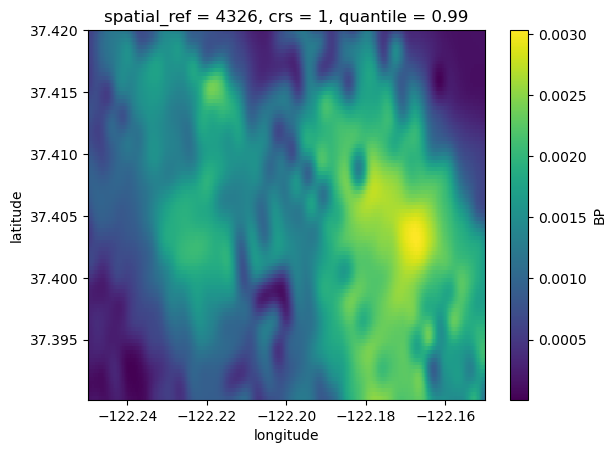

In [106]:
# wind_informed_bp_corrected.sel(
#     latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])
# ).BP.plot()

# smoothing across boundaries
- gap filling single pixels (optional - not top priority; do this by interpolting and then using a mask that only looks for single pixels?)
- small gaussian filter across the whole domain. options:
1. splice wind-smeared onto nearest neighbor 30m riley and blur it all (no interpolation)
2. take max of the smoothed and the not-smoothed

In [162]:
import cv2 as cv

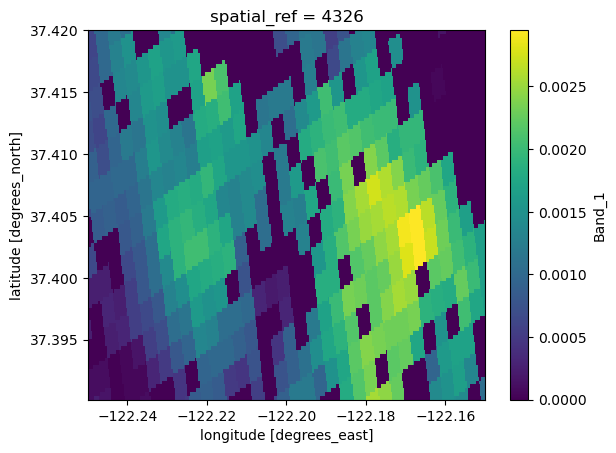

In [167]:
reprojected_riley.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

In [30]:
valid_pixels = reprojected_riley.BP>0

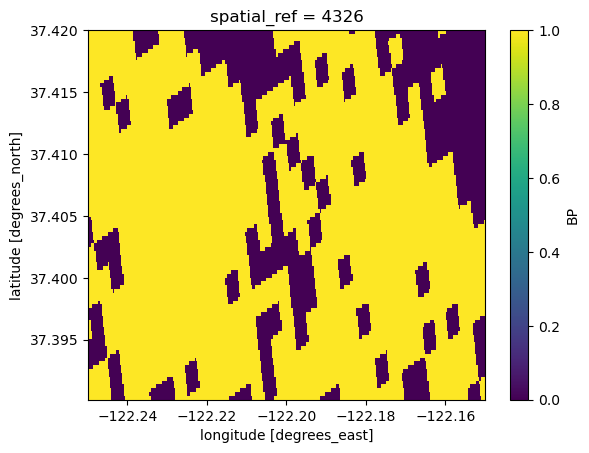

In [31]:
valid_pixels.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot()

In [190]:
reprojected_riley = reprojected_riley.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                                 'longitude': wind_informed_bp_30m_4326.longitude})

In [201]:
# Splice wind-smeared onto nearest neighbor 30m riley and blur it all (no interpolation)
wind_informed_bp_corrected = xr.where(
    reprojected_riley > 0, reprojected_riley, wind_informed_bp_30m_4326
)

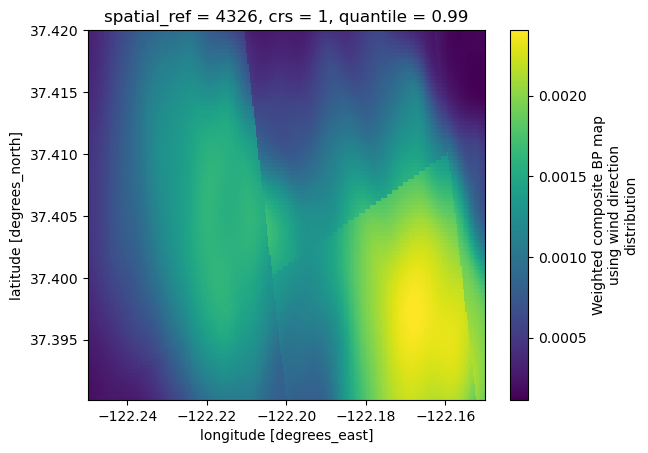

In [219]:
wind_informed_bp_30m_4326.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot()

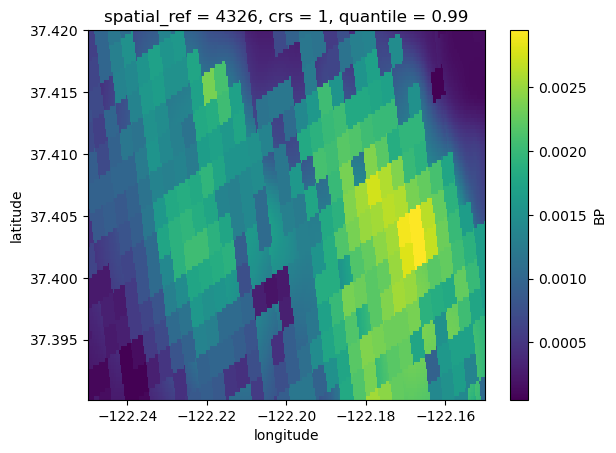

In [202]:
wind_informed_bp_corrected.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

# Steps
1.  Gap fill pixels in Riley 270 which are surrounded on four sides. Fill with the mean of a moving filter mean (TODO mask those pixels)
2.  Reproject and downsample to 30m using nearest neighbor (justification: 
3.  Substitute in wind-smeared version wherever there are zero values (Justification: we want to create valid burn probability numbers where they didn't have them in Fsim)
4.  Smooth using a Gaussian filter (justification: remove spatial artifacts 

In [212]:
arr = cv.GaussianBlur(wind_informed_bp_corrected.BP.values, (21, 21), 0)
blurred = xr.Dataset(
                            data_vars={'BP': ((reprojected_riley.dims, arr.astype(np.float32)))},
                            coords=reprojected_riley.coords,
                        )

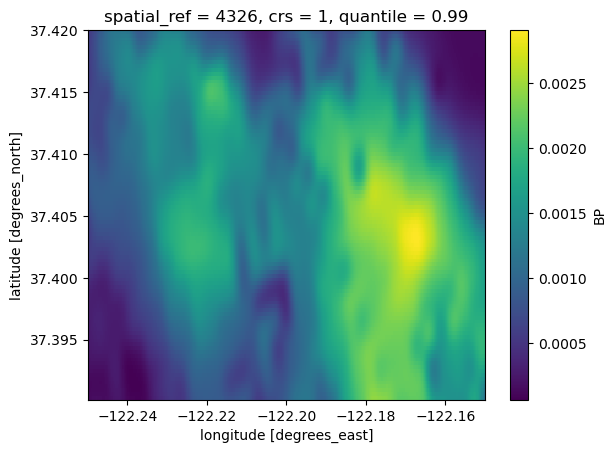

In [213]:
blurred.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

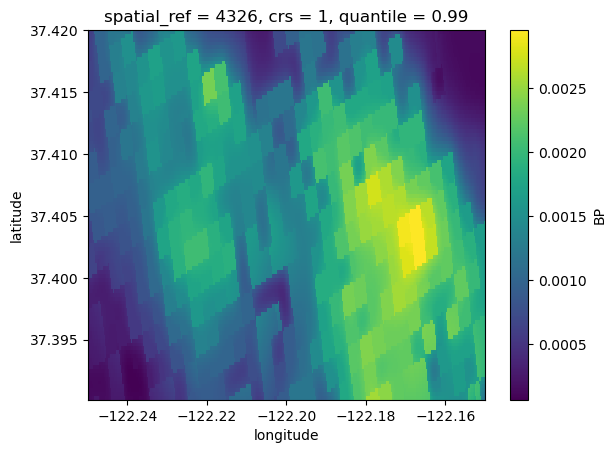

In [216]:
xr.ufuncs.maximum(blurred, wind_informed_bp_corrected).sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

In [127]:
def gap_fill(da):
    da = da.rio.write_nodata(np.nan)
    interpolated = da.rio.interpolate_na('cubic')
    mask_of_one_pixel_buffer_filled = (
        interpolated.bfill(dim='x', limit=1).fillna(0)
        + interpolated.ffill(dim='x', limit=1).fillna(0)
        + interpolated.bfill(dim='y', limit=1).fillna(0)
        + interpolated.ffill(dim='y', limit=1).fillna(0)
    )
    return xr.where(mask_of_one_pixel_buffer_filled > 0, interpolated, 0)

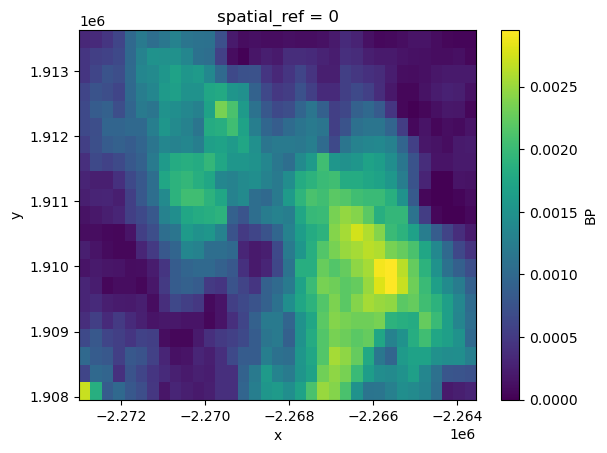

In [128]:
gap_filled = gap_fill(riley_2011_270m_5070_subset_nans['BP'])
geo_sel(gap_filled, bbox=bbox, crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt']).plot()

Text(0.5, 1.0, 'Gap-filled - Original')

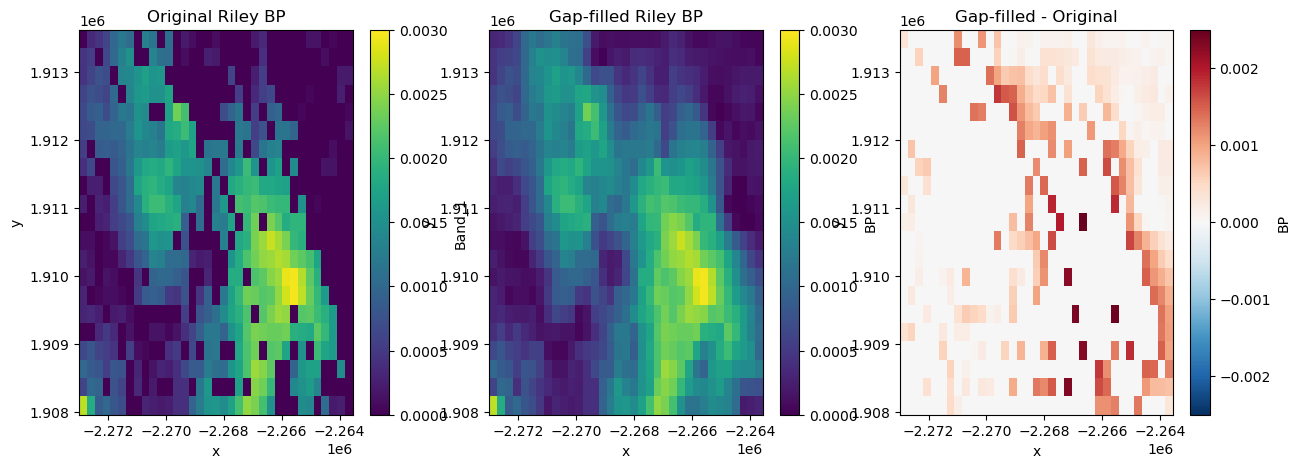

In [137]:
fig, axarr = plt.subplots(ncols=3, figsize=(15,5))
geo_sel(
    riley_bp_original.BP,
    bbox=bbox,
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
).plot(ax=axarr[0], vmax=0.003)
axarr[0].set_title('Original Riley BP')
geo_sel(
    gap_fill(riley_2011_270m_5070_subset_nans['BP']),
    bbox=bbox,
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
).plot(ax=axarr[1], vmax=0.003)
axarr[1].set_title('Gap-filled Riley BP')

geo_sel(
    gap_fill(riley_2011_270m_5070_subset_nans['BP'])-riley_bp_original.BP,
    bbox=bbox,
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
).plot(ax=axarr[2], vmax=0.0025, vmin=-0.0025, cmap='RdBu_r')
axarr[2].set_title('Gap-filled - Original')


In [51]:
filling_mask['spatial_ref'].attrs = riley_2011_270m_5070_subset['spatial_ref'].attrs

In [73]:
gap_filled = gap_filled.to_dataset(name='BP')

In [86]:
three_iterations, out_dict = apply_wind_directional_convolution(reprojected_riley.BP, iterations=3)

three_iterations = three_iterations.assign_coords(
    {
        'latitude': wind_direction_distribution_30m_4326.latitude,
        'longitude': wind_direction_distribution_30m_4326.longitude,
    }
)
wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(
    three_iterations, wind_direction_distribution_30m_4326
)
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
## average wind_informed_bp to 270m
wind_informed_bp_270m_5070 = xr_reproject(
    wind_informed_bp_30m_4326, how=riley_2011_270m_5070_subset.odc.geobox, resampling='average'
)
##  put non-zero numbers into where zero numbers were before
# riley_2011_270m_5070_subset = riley_2011_270m_5070_subset.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
#                                                                  'longitude': wind_informed_bp_30m_4326.longitude})

here2


/Users/orianachegwidden/ocr/ocr/risks/fire.py:181: RuntimeWarning: invalid value encountered in divide
  arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)


In [105]:
# reprojected_riley_gap_filled = assign_crs(reprojected_riley_gap_filled, 'EPSG:5070')
gap_filled['spatial_ref'].attrs = riley_2011_270m_5070_subset['spatial_ref'].attrs
reprojected_riley_gap_filled = xr_reproject(
    gap_filled, how=riley_2011_30m_4326_subset.odc.geobox, resampling='cubic', resolution='same'
)
reprojected_riley_gap_filled = reprojected_riley_gap_filled.assign_coords(
    {
        'latitude': wind_informed_bp_30m_4326.latitude,
        'longitude': wind_informed_bp_30m_4326.longitude,
    }
)
# retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid

In [106]:
wind_informed_bp_corrected = xr.where(
    reprojected_riley_gap_filled > 0, reprojected_riley_gap_filled, wind_informed_bp_30m_4326
)

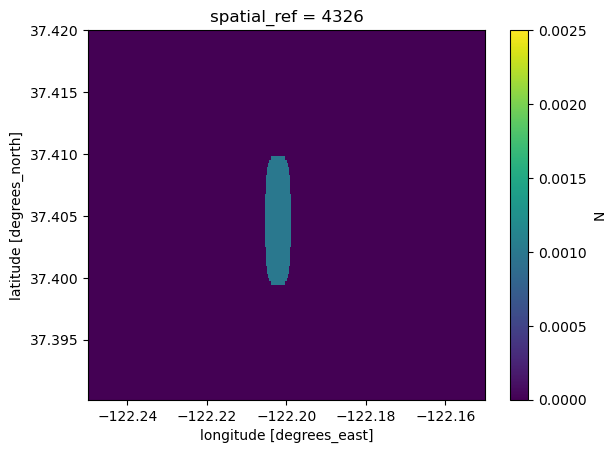

In [133]:
bbox = [-122.25, 37.39, -122.15, 37.42]

spread_results['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(
    vmin=0, vmax=0.0025
)

In [233]:
valid_riley = (geo_sel(
    riley_bp_original.BP,
    bbox=bbox,
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
) > 0)

In [293]:
da = xr.DataArray(np.ones((3,3)), coords={'x': np.arange(13,16),
                                          'y': np.arange(13,16)})

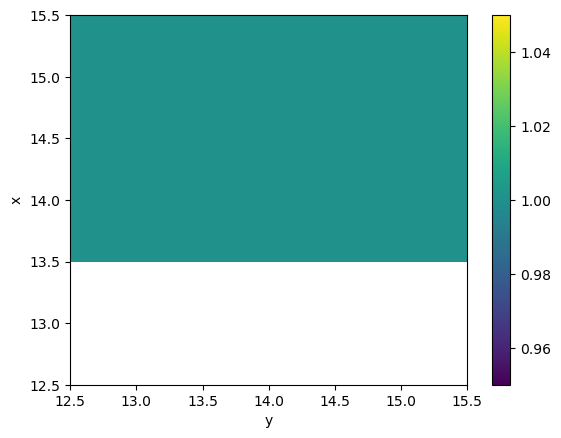

In [295]:
da.shift(x=1).plot()

In [297]:
shifted_riley = valid_riley.shift(y=2).assign_coords({'x': valid_riley.x,
                                                     'y': valid_riley.y}).drop('spatial_ref')

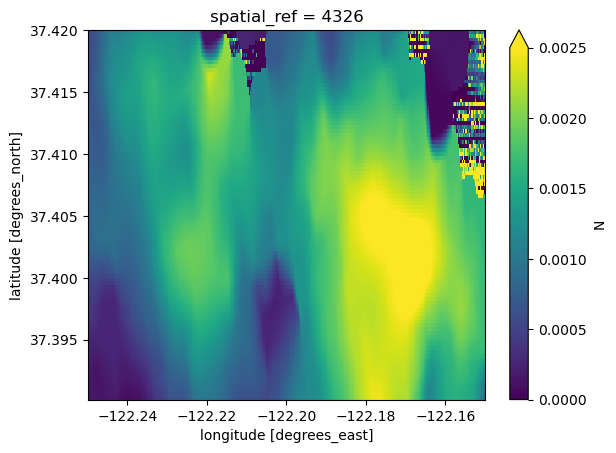

In [21]:
bbox = [-122.25, 37.39, -122.15, 37.42]

one_iteration['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(
    vmin=0, vmax=0.0025
)

In [22]:
two_iterations = apply_wind_directional_convolution(reprojected_riley.BP, iterations=2)

here
ERROR! Session/line number was not unique in database. History logging moved to new session 201


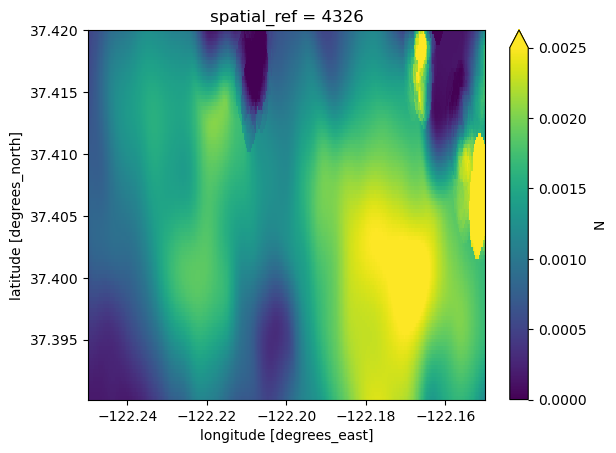

In [23]:
two_iterations['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(
    vmin=0, vmax=0.0025
)

In [101]:
bbox = [-122.18, 37.41, -122.15, 37.42]
spread_results, convolved_mask, convolved_arr, arr, valid_mask = apply_wind_directional_convolution(
    reprojected_riley.BP.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])),
    iterations=1,
)

here
her
her
her
her
her
her
init
her
her


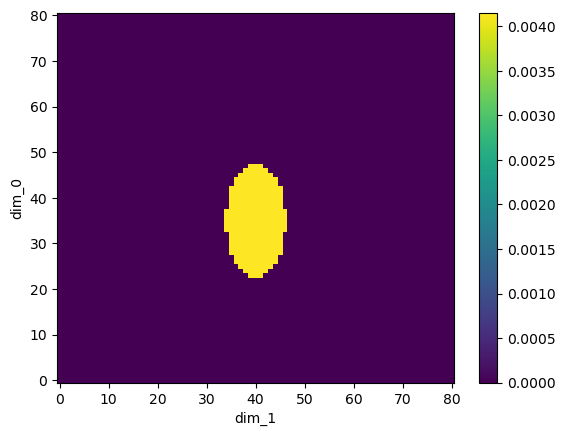

In [110]:
xr.DataArray(weights_dict['N']).plot()

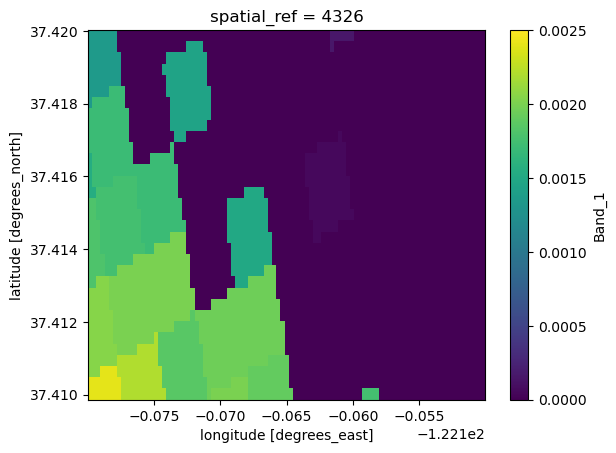

In [108]:
reprojected_riley.BP.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(
    vmax=0.0025
)

In [111]:
spread_results['N'].shape

(33, 97)

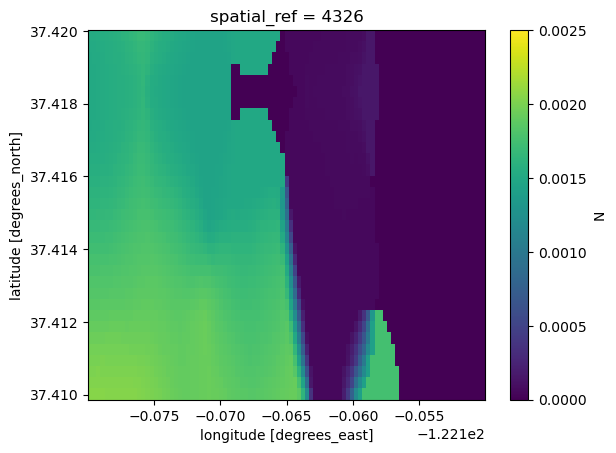

In [109]:
spread_results['N'].plot(vmax=0.0025)

In [118]:
xr.DataArray(valid_mask).plot()

NameError: name 'valid_mask' is not defined

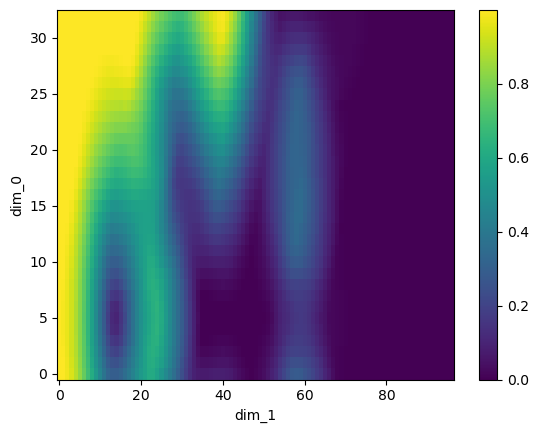

In [105]:
xr.DataArray(convolved_mask).plot()

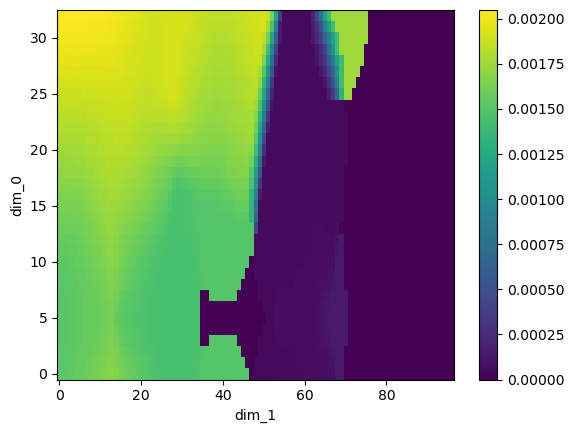

In [106]:
(xr.DataArray(arr)).plot()

In [67]:
xr.DataArray(arr).max()  # .plot()

<xarray.DataArray ()> Size: 8B
array(0.08398437)

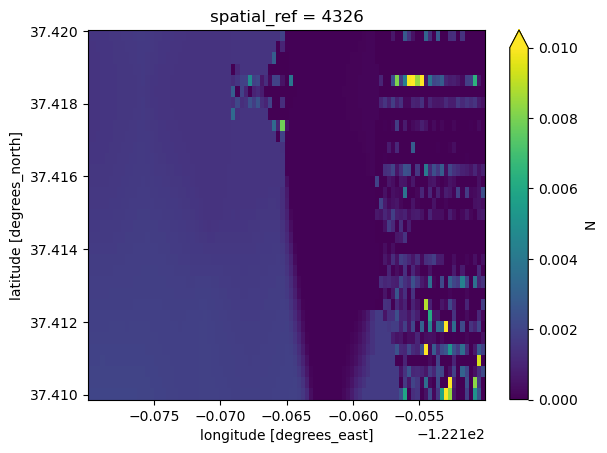

In [35]:
one_iteration['N'].plot(vmax=0.01)

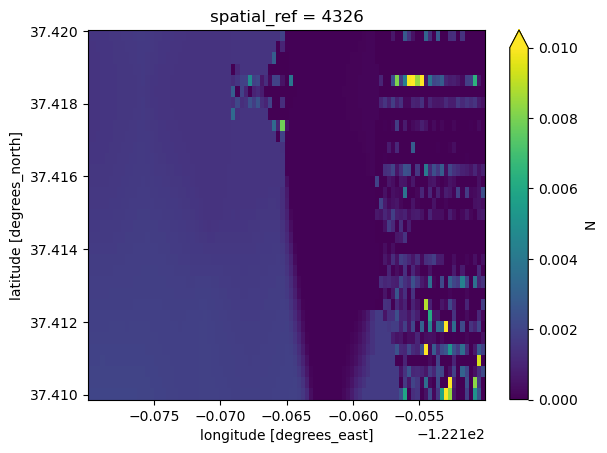

In [38]:
one_iteration['N'].plot(vmax=0.01)